In [1]:
import h5py
import pandas as pd
import numpy as np
import os
import pickle

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from sklearn.metrics import roc_auc_score

In [2]:
color_main = "black"
color_alt = "darkred"

# Figure 2 colors
fig2_colors = {
    'A vs B': '#1f77b4',   # blue
    'C vs D': '#ff7f0e',   # orange
    'E vs F': '#1f77b4',   # blue (same as A vs B)
    'G vs H': '#ff7f0e',   # orange (same as C vs D)
    'Reward': '#2ca02c',   # green
    'Lick': '#d62728',     # red
}

def set_pub_style():
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.8,
        "lines.markersize": 5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.25,
    })

def prettify(ax, title=None, xlabel=None, ylabel=None, add_legend=False):
    """Unified styling for axes."""
    if title: ax.set_title(title, pad=10)
    if xlabel: ax.set_xlabel(xlabel, labelpad=5)
    if ylabel: ax.set_ylabel(ylabel, labelpad=5)
    ax.grid(alpha=0.0, linestyle="--", linewidth=0.7)
    if add_legend: 
        ax.legend(frameon=False)
    for spine in ["left", "bottom"]:
        ax.spines[spine].set_linewidth(1.0)

set_pub_style()

In [3]:
def load_from_h5(h5_path, mouse_id, trial_id):
    with h5py.File(h5_path, 'r') as f:
        grp = f[f"{mouse_id}/{trial_id}"]
        
        place_maps = grp['place_maps'][:]
        smooth_place_maps = grp['smooth_place_maps'][:]
        
        trials_table = pd.DataFrame({
            'lap_index': grp['lap_index'][:],
            'context': grp['context'][:].astype(str),  # decode bytes back to str
            'reward_trial': grp['reward_trial'][:],
            'water': grp['water'][:],
            'lick_or_not': grp['lick_or_not'][:],
        })
        
    return place_maps, smooth_place_maps, trials_table

In [4]:
H5_PATH = 'all_sessions.h5'
MOUSE_ID = 'ek231'
ABCD_SESSIONS = [38933, 38945, 38946, 38959]
LEARNING_SESSION = 38981
EFGH_SESSIONS = [38982, 38997, 39016, 39019]
WINDOW_SIZE = 20

# Computations

In [5]:
def process_behavior(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, window=20, cache_path='cache/fig1d.pkl', recompute=False):

    def process():
        def calc_metrics(trials_table):
            rw = trials_table['reward_trial'].values == True
            lick = trials_table['lick_or_not'].values == True
            n_rw, n_nr = rw.sum(), (~rw).sum()
            hit = (rw & lick).sum() / n_rw if n_rw > 0 else np.nan
            cr = (~rw & ~lick).sum() / n_nr if n_nr > 0 else np.nan
            perf = ((rw & lick).sum() + (~rw & ~lick).sum()) / len(trials_table)
            return hit, cr, perf

        def calc_rolling(trials_table, w):
            rw = trials_table['reward_trial'].values == True
            lick = trials_table['lick_or_not'].values == True
            n = len(trials_table)
            hits, crs, perfs = [], [], []
            for i in range(n):
                s, e = max(0, i - w // 2), min(n, i + w // 2)
                rw_w, lick_w = rw[s:e], lick[s:e]
                n_rw, n_nr = rw_w.sum(), (~rw_w).sum()
                hits.append((rw_w & lick_w).sum() / n_rw if n_rw > 0 else np.nan)
                crs.append((~rw_w & ~lick_w).sum() / n_nr if n_nr > 0 else np.nan)
                perfs.append(((rw_w & lick_w).sum() + (~rw_w & ~lick_w).sum()) / (e - s))
            return np.array(hits), np.array(crs), np.array(perfs)

        abcd = [calc_metrics(load_from_h5(h5_path, mouse_id, s)[2]) for s in abcd_sessions]
        efgh = [calc_metrics(load_from_h5(h5_path, mouse_id, s)[2]) for s in efgh_sessions]
        _, _, learn_tbl = load_from_h5(h5_path, mouse_id, learning_session)
        learn_roll = calc_rolling(learn_tbl, window)
        return {'abcd': abcd, 'efgh': efgh, 'learning': learn_roll, 'n_laps': len(learn_tbl)}

    if not recompute and os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            data = pickle.load(f)
    else:
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        data = process()
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)

    return data

In [6]:
def process_population_decoding(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path='cache/fig2a.pkl', recompute=False):

    def process():
        def decode_per_bin(rasters, y):
            n_bins = rasters.shape[2]
            loo = LeaveOneOut()
            accs = np.zeros(n_bins)
            y = np.asarray(y)
            for b in range(n_bins):
                X = rasters[:, :, b].T
                preds = np.empty(len(y), dtype=object)
                for train_idx, test_idx in loo.split(X):
                    clf = SVC(kernel='linear')
                    clf.fit(X[train_idx], y[train_idx])
                    preds[test_idx] = clf.predict(X[test_idx])
                accs[b] = (preds == y).mean()
            return accs

        def process_session(sess):
            _, smooth_pm, trials_table = load_from_h5(h5_path, mouse_id, sess)
            n_trials = len(trials_table)
            smooth_pm = smooth_pm[:, :n_trials, :]
            ctx = trials_table['context'].values
            ab_mask = (ctx == 'ctxA') | (ctx == 'ctxB')
            cd_mask = (ctx == 'ctxC') | (ctx == 'ctxD')
            return sess, {
                'A vs B': decode_per_bin(smooth_pm[:, ab_mask, :], ctx[ab_mask]),
                'C vs D': decode_per_bin(smooth_pm[:, cd_mask, :], ctx[cd_mask]),
                'Reward': decode_per_bin(smooth_pm, trials_table['reward_trial'].values),
                'Lick': decode_per_bin(smooth_pm, trials_table['lick_or_not'].values),
            }

        all_sessions = abcd_sessions + [learning_session] + efgh_sessions
        res_list = Parallel(n_jobs=-1, verbose=10)(delayed(process_session)(s) for s in all_sessions)
        return {sess: res for sess, res in res_list}

    if not recompute and os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            data = pickle.load(f)
    else:
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        data = process()
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)

    return data

In [7]:
def process_pca_trajectories(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path='cache/fig2b.pkl', recompute=False):

    def process():
        def compute_pca_trajectories(smooth_pm, trials_table, label_type='context'):
            n_trials = len(trials_table)
            rasters = smooth_pm[:, :n_trials, :]
            n_bins = rasters.shape[2]

            if label_type == 'context':
                labels = trials_table['context'].values
            elif label_type == 'reward':
                labels = trials_table['reward_trial'].values.astype(str)
            elif label_type == 'lick':
                labels = trials_table['lick_or_not'].values.astype(str)

            unique_labels = np.unique(labels)
            mean_activity = []
            for lbl in unique_labels:
                lbl_trials = rasters[:, labels == lbl, :]
                lbl_mean = np.mean(lbl_trials, axis=1)
                mean_activity.append(lbl_mean.T)

            all_means = np.vstack(mean_activity)
            pca = PCA(n_components=2)
            pca_proj = pca.fit_transform(all_means)

            trajectories = {}
            for i, lbl in enumerate(unique_labels):
                start = i * n_bins
                end = (i + 1) * n_bins
                trajectories[lbl] = pca_proj[start:end]

            return trajectories

        def process_session(sess):
            _, smooth_pm, trials_table = load_from_h5(h5_path, mouse_id, sess)
            return sess, {
                'context': compute_pca_trajectories(smooth_pm, trials_table, 'context'),
                'reward': compute_pca_trajectories(smooth_pm, trials_table, 'reward'),
                'lick': compute_pca_trajectories(smooth_pm, trials_table, 'lick'),
            }

        all_sessions = abcd_sessions + [learning_session] + efgh_sessions
        return {sess: process_session(sess)[1] for sess in tqdm(all_sessions)}

    if not recompute and os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            data = pickle.load(f)
    else:
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        data = process()
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)

    return data

In [8]:
def process_single_neuron(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions,
                          cache_path='cache/fig3a.pkl', recompute=False):

    def process():
        def decode_single_neuron_session(h5_path, mouse_id, sess):
            _, smooth_pm, trials_table = load_from_h5(h5_path, mouse_id, sess)
            n_trials = len(trials_table)
            smooth_pm = smooth_pm[:, :n_trials, :]
            n_neurons, _, n_bins = smooth_pm.shape

            ctx = trials_table['context'].values
            ab_mask = (ctx == 'ctxA') | (ctx == 'ctxB')
            cd_mask = (ctx == 'ctxC') | (ctx == 'ctxD')

            targets = {
                'A vs B':  (smooth_pm[:, ab_mask, :], ctx[ab_mask]),
                'C vs D':  (smooth_pm[:, cd_mask, :], ctx[cd_mask]),
                'Reward':  (smooth_pm, trials_table['reward_trial'].values),
                'Lick':    (smooth_pm, trials_table['lick_or_not'].values),
            }

            def decode_neuron(neuron_idx, rasters, y):
                n_bins = rasters.shape[2]
                y = np.asarray(y)
                loo = LeaveOneOut()
                accs = np.zeros(n_bins)
                aucs = np.zeros(n_bins)
                classes = np.unique(y)

                for b in range(n_bins):
                    X = rasters[neuron_idx, :, b].reshape(-1, 1)
                    preds = np.empty(len(y), dtype=y.dtype)
                    decision = np.zeros(len(y))

                    for train_idx, test_idx in loo.split(X):
                        clf = SVC(kernel='linear', decision_function_shape='ovr')
                        clf.fit(X[train_idx], y[train_idx])
                        preds[test_idx] = clf.predict(X[test_idx])
                        decision[test_idx] = clf.decision_function(X[test_idx].reshape(1, -1))

                    accs[b] = (preds == y).mean()
                    try:
                        y_bin = (y == classes[1]).astype(int)
                        aucs[b] = roc_auc_score(y_bin, decision)
                    except (ValueError, IndexError):
                        aucs[b] = 0.5

                return accs, aucs

            sess_result = {}
            for tgt_name, (rasters, y) in targets.items():
                n_neurons_tgt = rasters.shape[0]
                res = Parallel(n_jobs=-1)(
                    delayed(decode_neuron)(ni, rasters, y)
                    for ni in range(n_neurons_tgt)
                )
                acc_mat = np.array([r[0] for r in res])
                auc_mat = np.array([r[1] for r in res])
                sess_result[tgt_name] = {'accuracy': acc_mat, 'roc_auc': auc_mat}

            return sess, sess_result

        all_sessions = abcd_sessions + [learning_session] + efgh_sessions
        results = {}
        for sess in tqdm(all_sessions, desc='Sessions'):
            s, res = decode_single_neuron_session(h5_path, mouse_id, sess)
            results[s] = res
        return results

    if not recompute and os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            data = pickle.load(f)
    else:
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        data = process()
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)

    return data

# Main Figures

In [9]:
def figure_1d(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, window=20, cache_path='cache/fig1d.pkl', recompute=False):

    data = process_behavior(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, window, cache_path, recompute)

    set_pub_style()
    fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=300)

    for ax, metrics, sessions, title in [
        (axes[0], data['abcd'], abcd_sessions, 'Expert ABCD'),
        (axes[2], data['efgh'], efgh_sessions, 'Expert EFGH')
    ]:
        hits, crs, perfs = zip(*metrics)
        days = np.arange(1, len(sessions) + 1)
        ax.plot(days, perfs, '-', label='Performance', color=color_main)
        ax.plot(days, hits, '--', label='HIT', color=color_alt, alpha=1.0)
        ax.plot(days, crs, '-', label='Correct Rejection', color=color_alt, alpha=1.0)
        prettify(ax, title=title, xlabel='Day')
        ax.set_xticks(days)

    laps = np.arange(1, data['n_laps'] + 1)
    hit_r, cr_r, perf_r = data['learning']
    axes[1].plot(laps, perf_r, '-', label='Performance', color=color_main)
    axes[1].plot(laps, hit_r, '--', label='HIT', color=color_alt, alpha=1.0)
    axes[1].plot(laps, cr_r, '-', label='Correct Rejection', color=color_alt, alpha=1.0)
    prettify(axes[1], title='Fast Learning', xlabel='Lap')

    prettify(axes[0], ylabel='Accuracy')
    axes[0].set_ylim(0, 1.05)
    axes[2].legend(loc='lower right', frameon=False)
    plt.tight_layout()
    return fig

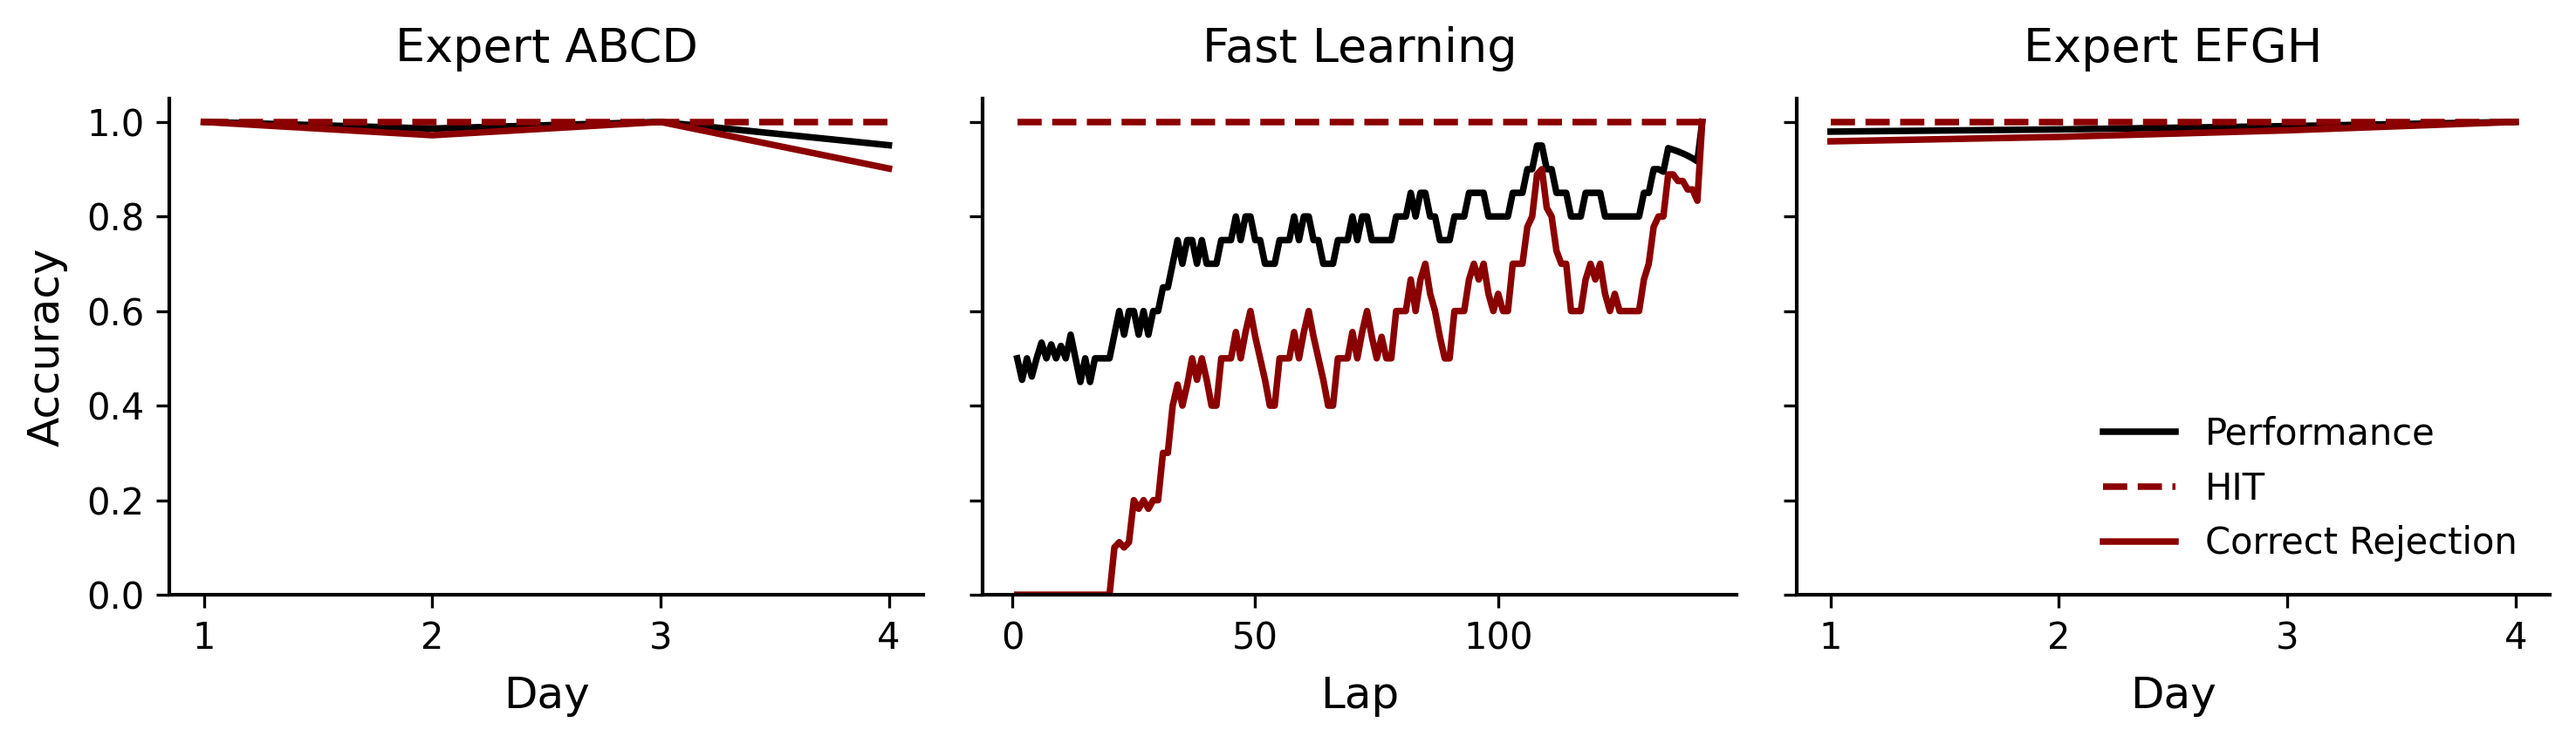

In [10]:
fig = figure_1d(H5_PATH, MOUSE_ID, ABCD_SESSIONS, LEARNING_SESSION, EFGH_SESSIONS, WINDOW_SIZE, recompute=False)

In [39]:
def figure_2(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path='cache/fig2a.pkl', recompute=False):

    data = process_population_decoding(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path, recompute)

    set_pub_style()
    fig, axes = plt.subplots(2, 9, figsize=(12, 5), sharey=True)
    x = np.arange(100)

    all_sessions = abcd_sessions + [learning_session] + efgh_sessions

    for col, sess in enumerate(all_sessions):
        is_efgh = col >= 5
        sess_data = data[sess]

        r_label = 'E vs F' if is_efgh else 'A vs B'
        nr_label = 'G vs H' if is_efgh else 'C vs D'

        axes[0, col].plot(x, sess_data['A vs B'], '-', color=color_alt, label=r_label)
        axes[0, col].axhline(0.5, color='gray', linestyle=':', linewidth=1)
        axes[0, col].set_ylim(0.3, 1.05)

        axes[1, col].plot(x, sess_data['C vs D'], '-', color=color_alt, label=nr_label)
        axes[1, col].axhline(0.5, color='gray', linestyle=':', linewidth=1)
        axes[1, col].set_ylim(0.3, 1.05)

        if col < 4:
            title = f'Day {col + 1}'
        elif col == 4:
            title = 'Learning'
        else:
            title = f'Day {col - 4}'
        prettify(axes[0, col], title=title, xlabel='Position')
        prettify(axes[1, col], title=title, xlabel='Position')

    prettify(axes[0, 0], ylabel='R Accuracy')
    prettify(axes[1, 0], ylabel='NR Accuracy')
    axes[0, 0].legend(loc='lower right', frameon=False, fontsize=7)
    axes[0, 5].legend(loc='lower right', frameon=False, fontsize=7)
    axes[1, 0].legend(loc='lower right', frameon=False, fontsize=7)
    axes[1, 5].legend(loc='lower right', frameon=False, fontsize=7)
    plt.tight_layout()
    return fig

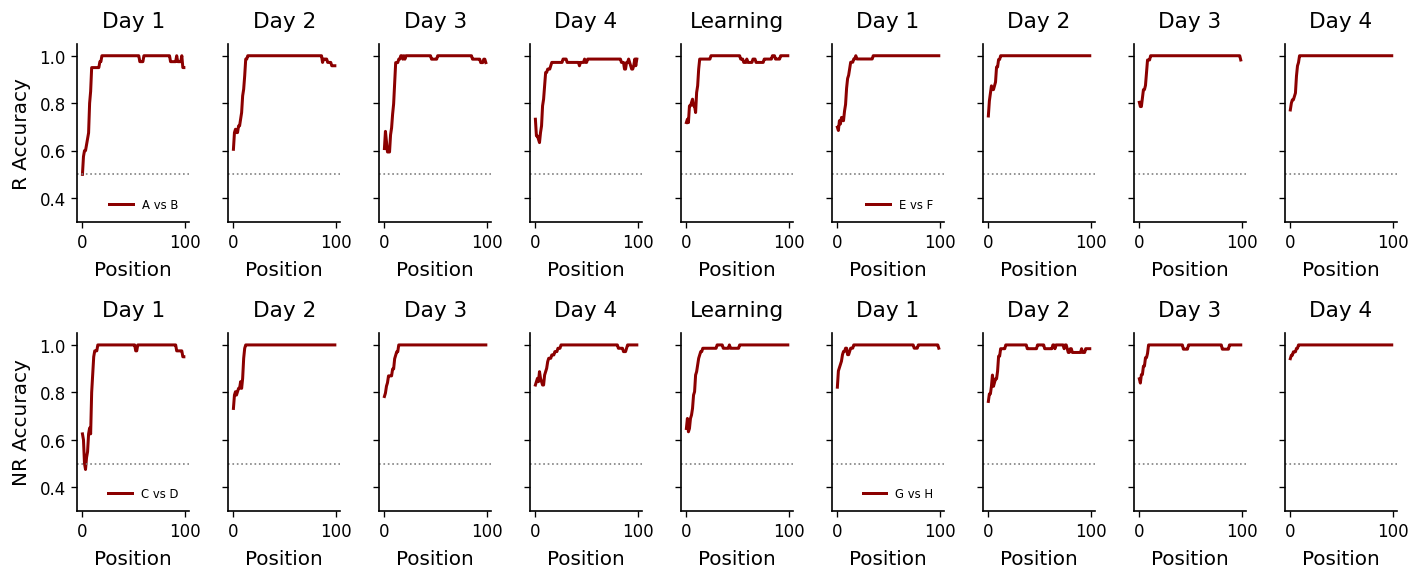

In [40]:
fig = figure_2(H5_PATH, MOUSE_ID, ABCD_SESSIONS, LEARNING_SESSION, EFGH_SESSIONS, recompute=False)

In [43]:
def figure_2c(h5_path, mouse_id, sessions, abcd_sessions, learning_session, efgh_sessions, cache_path='cache/fig2a.pkl', recompute=False):

    data = process_population_decoding(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path, recompute)

    set_pub_style()
    fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True, dpi=300)

    days = np.arange(1, len(sessions) + 1)
    r_accs = [np.mean(data[s]['A vs B']) for s in sessions]
    nr_accs = [np.mean(data[s]['C vs D']) for s in sessions]

    axes[0].plot(days, r_accs, '-o', color=color_alt)
    axes[0].set_ylim(0.3, 1.05)
    axes[0].set_xticks(days)
    prettify(axes[0], title='R', xlabel='Day', ylabel='Accuracy')

    axes[1].plot(days, nr_accs, '-o', color=color_alt)
    axes[1].set_ylim(0.3, 1.05)
    axes[1].set_xticks(days)
    prettify(axes[1], title='NR', xlabel='Day')

    plt.tight_layout()
    return fig

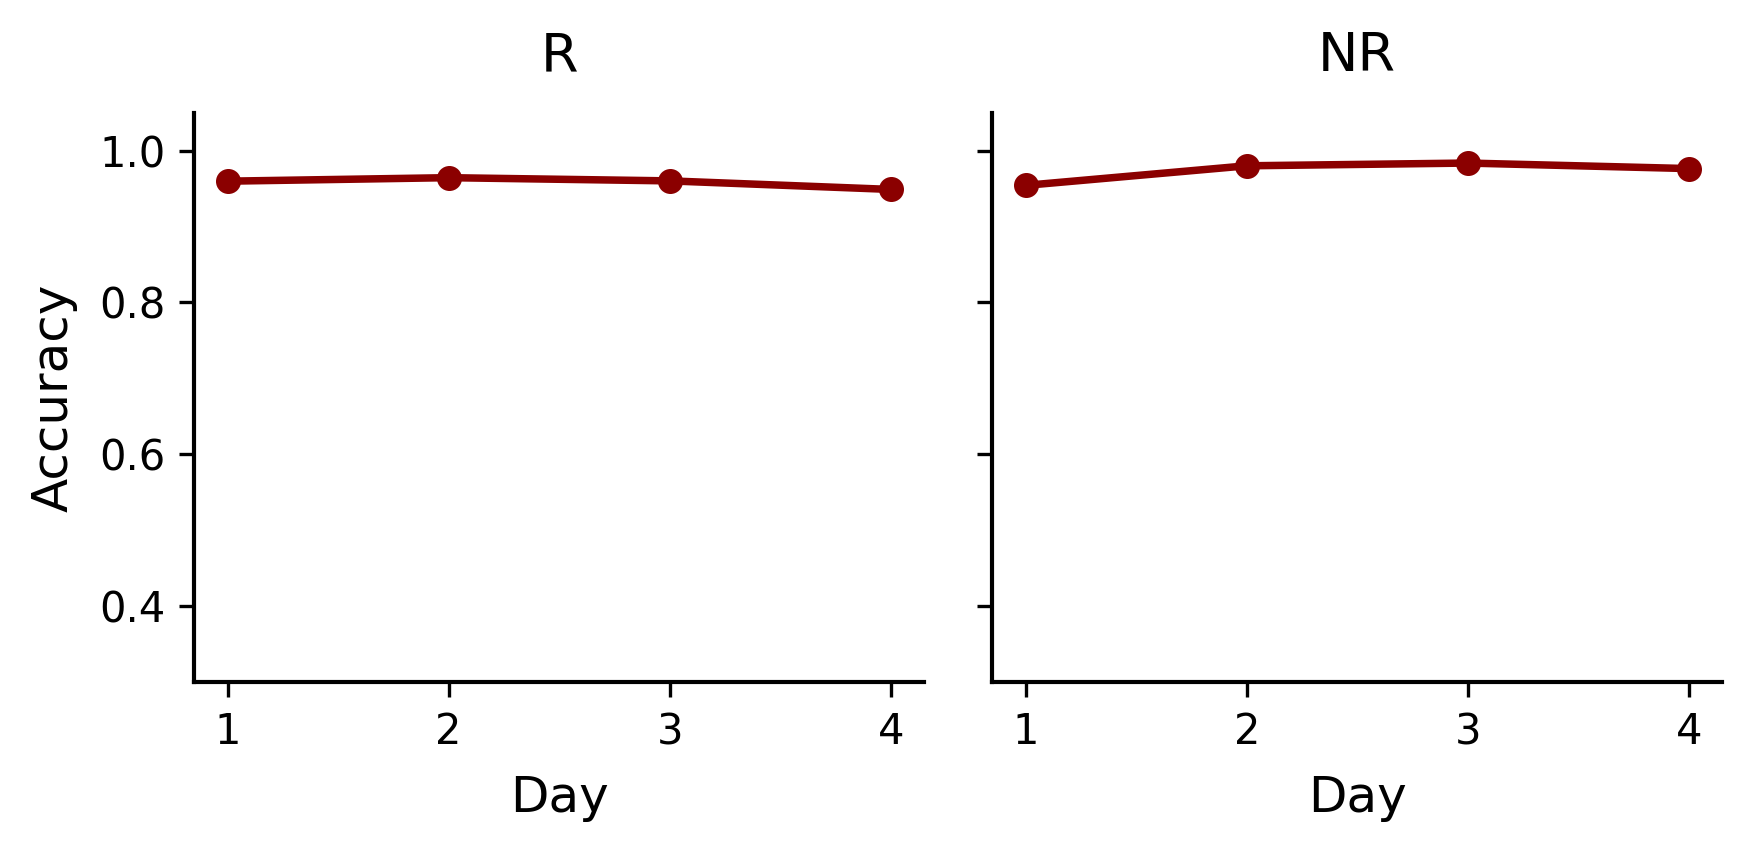

In [44]:
fig = figure_2c(H5_PATH, MOUSE_ID, ABCD_SESSIONS, ABCD_SESSIONS, LEARNING_SESSION, EFGH_SESSIONS)

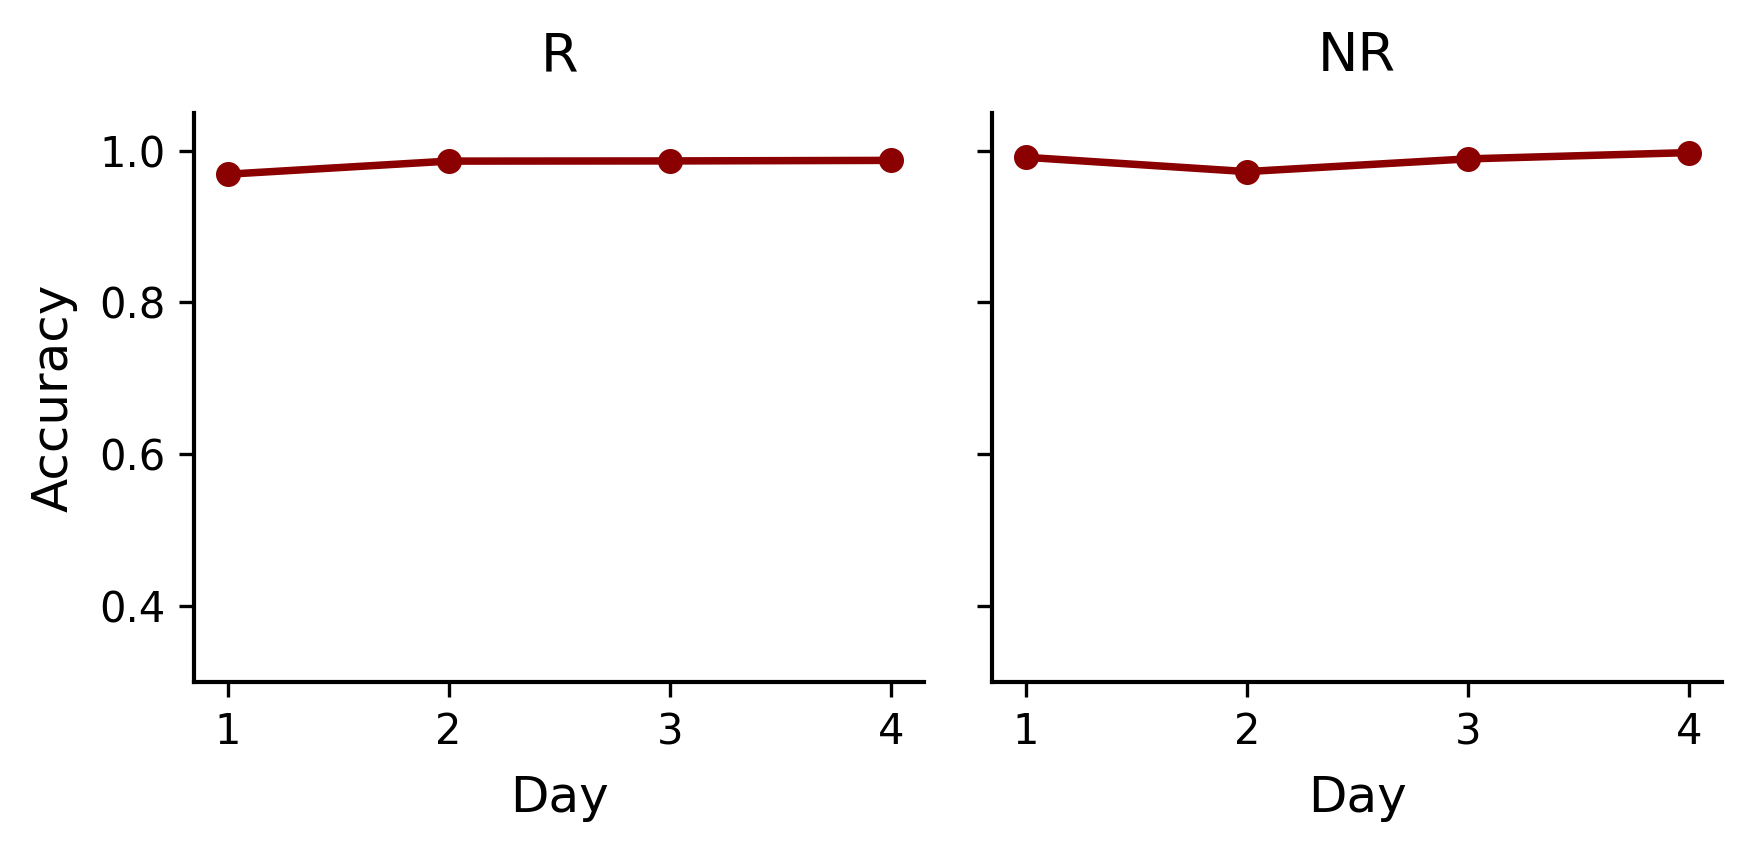

In [46]:
fig = figure_2c(H5_PATH, MOUSE_ID, EFGH_SESSIONS, ABCD_SESSIONS, LEARNING_SESSION, EFGH_SESSIONS)

# Supplementary Figures

In [11]:
def figure_2a_suppliment(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path='cache/fig2a.pkl', recompute=False):

    data = process_population_decoding(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path, recompute)

    set_pub_style()
    fig, axes = plt.subplots(1, 9, figsize=(20, 3), sharey=True)
    x = np.arange(100)

    def plot_session(ax, sess_data, is_efgh=False, show_legend=False):
        label_map = {'A vs B': 'E vs F', 'C vs D': 'G vs H'} if is_efgh else {}
        for key in ['A vs B', 'C vs D', 'Reward', 'Lick']:
            label = label_map.get(key, key)
            ax.plot(x, sess_data[key], '-', color=fig2_colors[label], label=label)
        ax.axhline(0.5, color='gray', linestyle=':', linewidth=1)
        ax.set_ylim(0.3, 1.05)
        ax.set_xlabel('Position')
        if show_legend:
            ax.legend(loc='center right', frameon=False, fontsize=6)

    for i, sess in enumerate(abcd_sessions):
        plot_session(axes[i], data[sess], is_efgh=False, show_legend=(i == 3))
        prettify(axes[i], title="Day " + str(i+1))

    plot_session(axes[4], data[learning_session], is_efgh=False)
    prettify(axes[4], title='Learning')

    for i, sess in enumerate(efgh_sessions):
        plot_session(axes[5 + i], data[sess], is_efgh=True, show_legend=(i == 3))
        prettify(axes[5 + i], title="Day " + str(i+1))

    prettify(axes[0], ylabel='Accuracy')
    plt.tight_layout()
    return fig

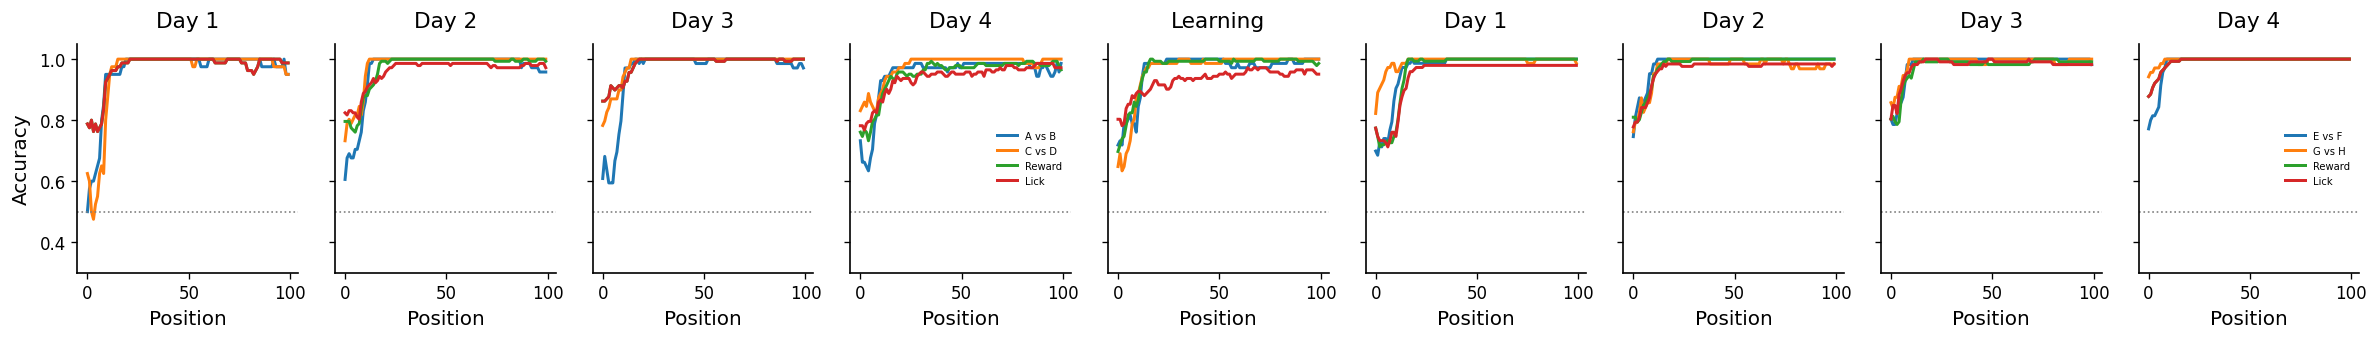

In [12]:
fig = figure_2a_suppliment(H5_PATH, MOUSE_ID, ABCD_SESSIONS, LEARNING_SESSION, EFGH_SESSIONS, recompute=False)

In [13]:
def figure_2b_suppliment(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path='cache/fig2b.pkl', recompute=False):

    data = process_pca_trajectories(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path, recompute)

    def plot_trajectory_gradient(ax, traj, label=None, cmap='Reds_r', linewidth=1.5):
        points = traj.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        norm = plt.Normalize(0, len(traj) - 1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=linewidth)
        lc.set_array(np.arange(len(traj)))
        ax.add_collection(lc)
        ax.scatter(traj[0, 0], traj[0, 1], s=40, c='darkred', marker='o', zorder=5)
        if label:
            mid_idx = len(traj) // 2
            ax.text(traj[mid_idx, 0], traj[mid_idx, 1], label, fontsize=7,
                    ha='center', va='center', color='black', weight='bold',
                    bbox=dict(boxstyle='round,pad=0.15', facecolor='white', alpha=0.7, edgecolor='none'))
        ax.autoscale()

    from matplotlib.colors import LinearSegmentedColormap
    cmap_darkred_black = LinearSegmentedColormap.from_list('darkred_black', ['darkred', 'black'])

    set_pub_style()
    fig, axes = plt.subplots(3, 10, figsize=(20, 6), gridspec_kw={'width_ratios': [1]*9 + [0.15]})

    context_labels_abcd = {
        'ctxA': 'A', 'ctxB': 'B', 'ctxC': 'C', 'ctxD': 'D',
    }
    context_labels_efgh = {
        'ctxA': 'E', 'ctxB': 'F', 'ctxC': 'G', 'ctxD': 'H',
    }
    reward_labels = {'True': 'Rw', 'False': 'No-Rw'}
    lick_labels = {'True': 'Lick', 'False': 'No-Lick'}

    all_sessions = abcd_sessions + [learning_session] + efgh_sessions
    n_bins = 100

    for col, sess in enumerate(all_sessions):
        sess_data = data[sess]
        context_labels = context_labels_efgh if col >= 4 else context_labels_abcd

        ax = axes[0, col]
        for lbl, traj in sess_data['context'].items():
            plot_trajectory_gradient(ax, traj, label=context_labels.get(lbl, lbl), cmap=cmap_darkred_black)
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel('Context\nPC2', fontsize=10)
        if col < 4:
            ax.set_title(f'Day {col+1}', fontsize=10)
        elif col == 4:
            ax.set_title('Learning', fontsize=10)
        else:
            ax.set_title(f'Day {col-4}', fontsize=10)

        ax = axes[1, col]
        for lbl, traj in sess_data['reward'].items():
            plot_trajectory_gradient(ax, traj, label=reward_labels.get(lbl, lbl), cmap=cmap_darkred_black)
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel('Reward\nPC2', fontsize=10)

        ax = axes[2, col]
        for lbl, traj in sess_data['lick'].items():
            plot_trajectory_gradient(ax, traj, label=lick_labels.get(lbl, lbl), cmap=cmap_darkred_black)
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel('Lick\nPC2', fontsize=10)
            ax.set_xlabel('PC1', fontsize=10)
        else:
            ax.set_xlabel('PC1', fontsize=10)

    norm = plt.Normalize(0, n_bins)
    for row in range(3):
        ax_cb = axes[row, 9]
        ax_cb.axis('off')
        sm = plt.cm.ScalarMappable(cmap=cmap_darkred_black, norm=norm)
        sm.set_array([])
        cb = fig.colorbar(sm, ax=ax_cb, fraction=0.9, aspect=15)
        cb.set_label('Position (bin)', fontsize=8)
        cb.set_ticks([0, 50, 100])

    plt.tight_layout()
    return fig

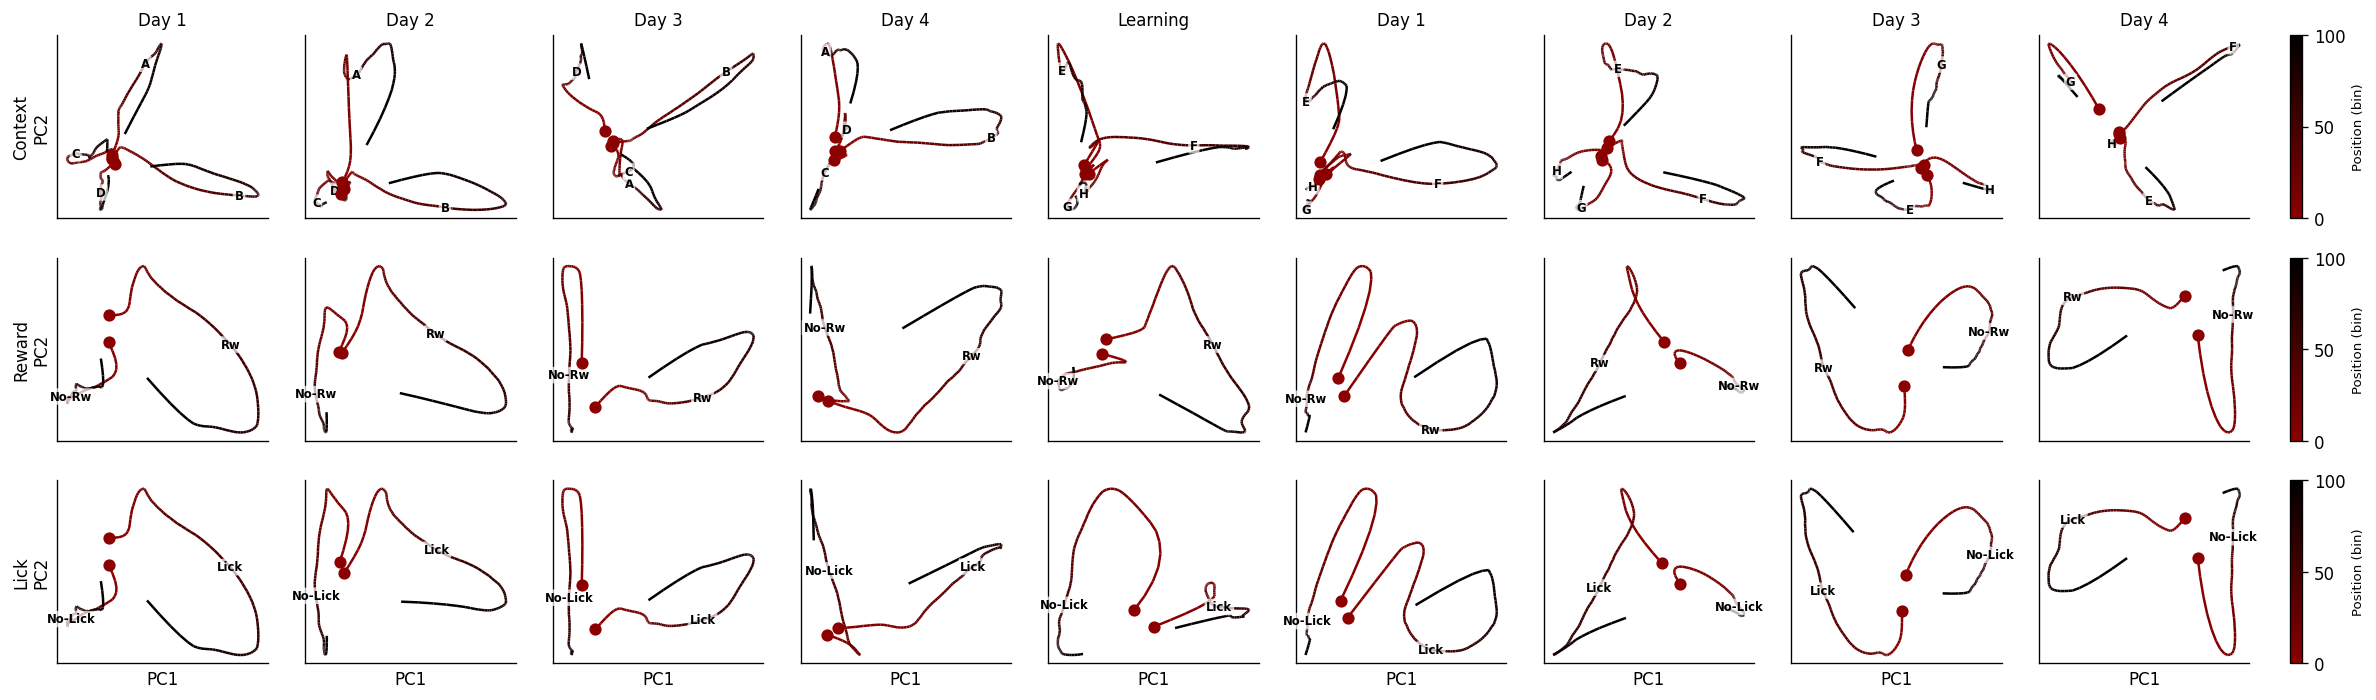

In [14]:
fig = figure_2b_suppliment(H5_PATH, MOUSE_ID, ABCD_SESSIONS, LEARNING_SESSION, EFGH_SESSIONS, recompute=False)

In [15]:
def figure_3a(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions,
              cache_path='cache/fig3a.pkl', recompute=False):

    data = process_single_neuron(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path, recompute)

    set_pub_style()

    target_keys = ['A vs B', 'C vs D', 'Reward', 'Lick']
    target_labels_abcd = {'A vs B': 'A vs B', 'C vs D': 'C vs D', 'Reward': 'Reward', 'Lick': 'Lick'}
    target_labels_efgh = {'A vs B': 'E vs F', 'C vs D': 'G vs H', 'Reward': 'Reward', 'Lick': 'Lick'}
    all_sessions = abcd_sessions + [learning_session] + efgh_sessions
    n_sessions = len(all_sessions)
    metric = 'accuracy'

    fig, axes = plt.subplots(4, n_sessions, figsize=(2.2 * n_sessions, 10))

    for col, sess in enumerate(all_sessions):
        sess_data = data[sess]
        is_efgh = col >= 4

        ab_acc = sess_data['A vs B'][metric]
        rw_acc = sess_data['Reward'][metric]

        sort_ctx = np.argsort(np.argmax(ab_acc, axis=1))
        sort_rwd = np.argsort(np.argmax(rw_acc, axis=1))

        sort_map = {
            'A vs B': sort_ctx,
            'C vs D': sort_ctx,
            'Reward': sort_rwd,
            'Lick':   sort_rwd,
        }

        target_labels = target_labels_efgh if is_efgh else target_labels_abcd

        for row, tgt in enumerate(target_keys):
            ax = axes[row, col]
            mat = sess_data[tgt][metric]
            order = sort_map[tgt]
            sorted_mat = mat[order, :]

            im = ax.imshow(sorted_mat, aspect='auto', cmap='Reds',
                           vmin=0.0, vmax=1.0, interpolation='none')

            if col == 0:
                ax.set_ylabel(target_labels[tgt], fontsize=10)

            if row == 0:
                if sess == learning_session:
                    title = 'Learning'
                elif col >= 5:
                    title = f'Day {col - 4}'
                else:
                    title = f'Day {col + 1}'
                ax.set_title(title, fontsize=10)

            if row == 3:
                ax.set_xlabel('Position')
            else:
                ax.set_xticklabels([])

            if col > 0:
                ax.set_yticklabels([])

    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax, label='Decoding Accuracy')
    cb.set_ticks([0, 0.5, 1])

    plt.subplots_adjust(wspace=0.08, hspace=0.15, right=0.9)
    return fig

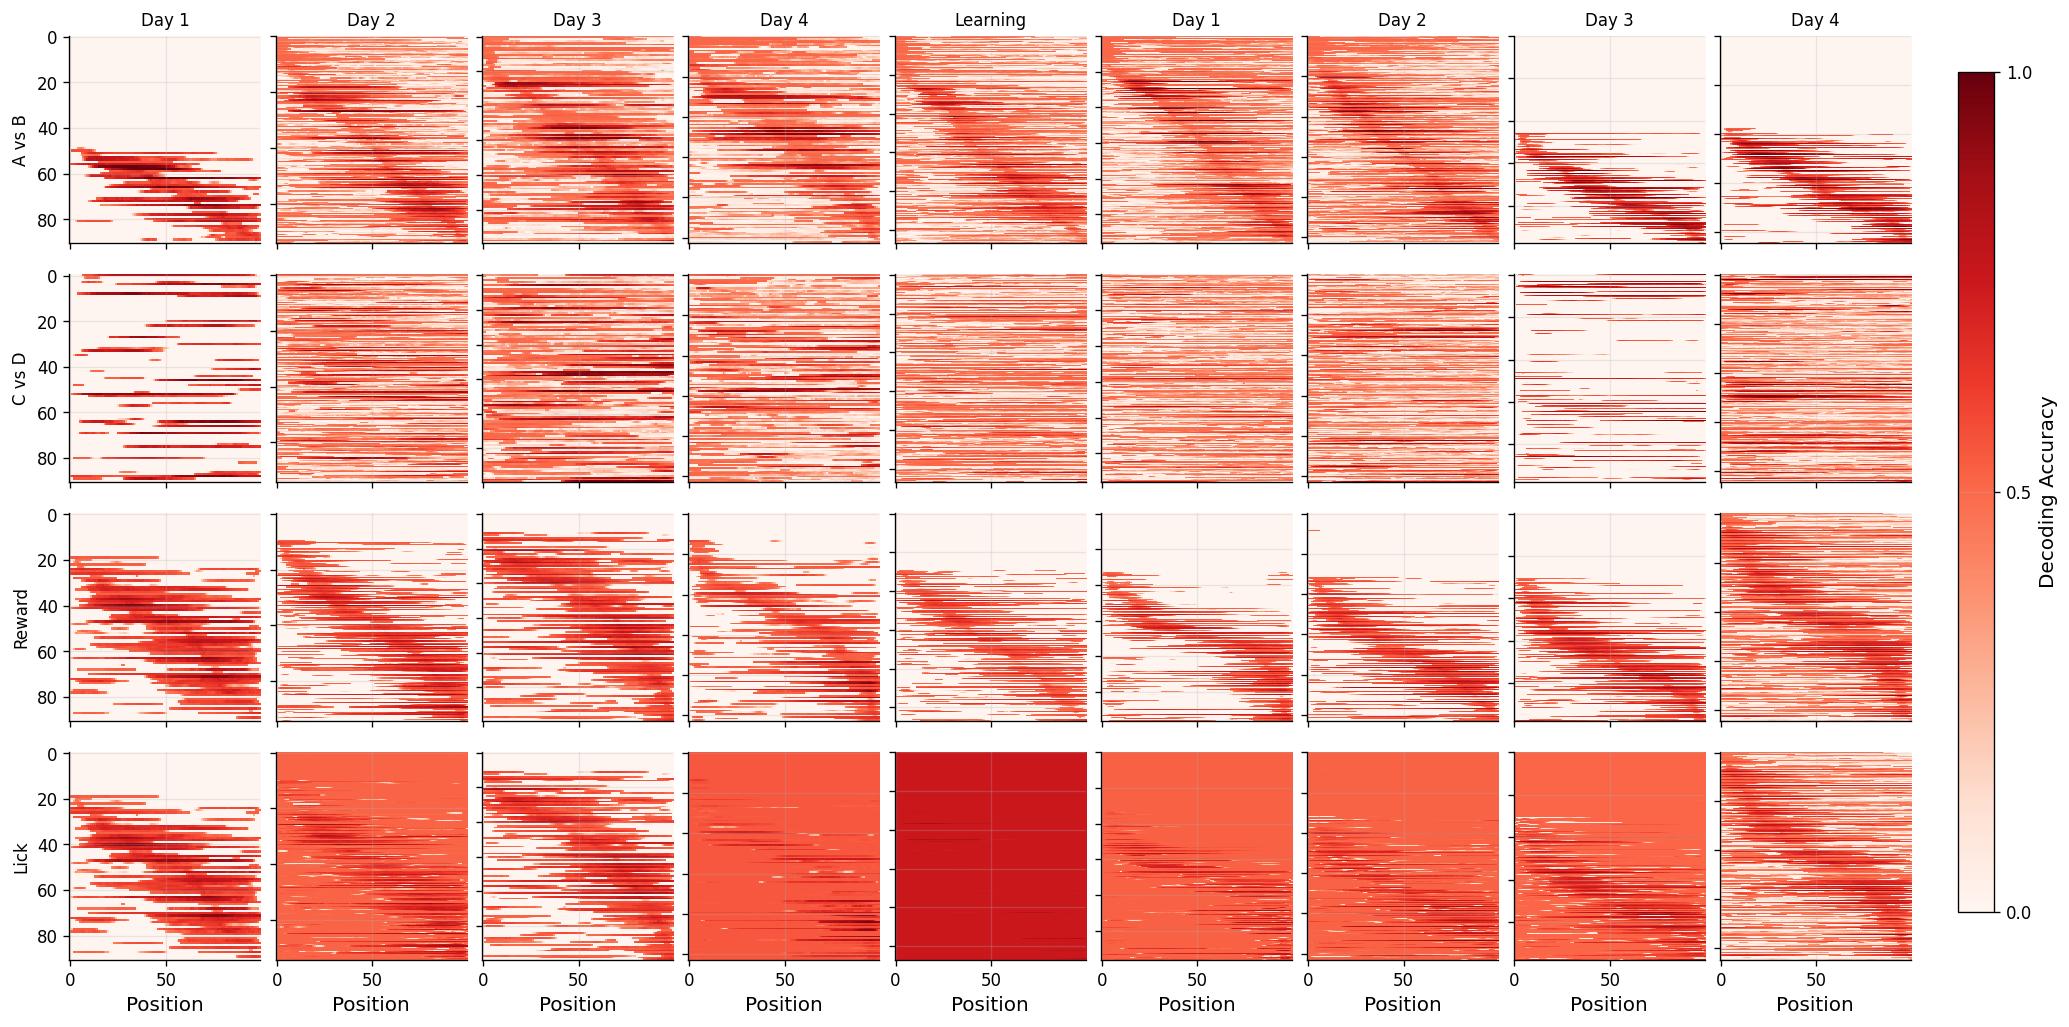

In [16]:
fig = figure_3a(H5_PATH, MOUSE_ID, ABCD_SESSIONS, LEARNING_SESSION, EFGH_SESSIONS, recompute=False)

In [17]:
def figure_3b(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path='cache/fig3a.pkl', recompute=False):

    data = process_single_neuron(h5_path, mouse_id, abcd_sessions, learning_session, efgh_sessions, cache_path, recompute)

    set_pub_style()

    target_keys = ['A vs B', 'C vs D', 'Reward', 'Lick']
    target_labels_abcd = {'A vs B': 'A vs B', 'C vs D': 'C vs D', 'Reward': 'Reward', 'Lick': 'Lick'}
    target_labels_efgh = {'A vs B': 'E vs F', 'C vs D': 'G vs H', 'Reward': 'Reward', 'Lick': 'Lick'}
    all_sessions = abcd_sessions + [learning_session] + efgh_sessions
    n_sessions = len(all_sessions)
    metric = 'roc_auc'

    fig, axes = plt.subplots(4, n_sessions, figsize=(2.2 * n_sessions, 10))

    for col, sess in enumerate(all_sessions):
        sess_data = data[sess]
        is_efgh = col >= 4

        ab_auc = sess_data['A vs B'][metric]
        rw_auc = sess_data['Reward'][metric]

        sort_ctx = np.argsort(np.argmax(ab_auc, axis=1))
        sort_rwd = np.argsort(np.argmax(rw_auc, axis=1))

        sort_map = {
            'A vs B': sort_ctx,
            'C vs D': sort_ctx,
            'Reward': sort_rwd,
            'Lick':   sort_rwd,
        }

        target_labels = target_labels_efgh if is_efgh else target_labels_abcd

        for row, tgt in enumerate(target_keys):
            ax = axes[row, col]
            mat = sess_data[tgt][metric]
            order = sort_map[tgt]
            sorted_mat = mat[order, :]

            im = ax.imshow(sorted_mat, aspect='auto', cmap='Reds',
                           vmin=0.0, vmax=1.0, interpolation='none')

            if col == 0:
                ax.set_ylabel(target_labels[tgt], fontsize=10)

            if row == 0:
                if sess == learning_session:
                    title = 'Learning'
                elif col >= 5:
                    title = f'Day {col - 4}'
                else:
                    title = f'Day {col + 1}'
                ax.set_title(title, fontsize=10)

            if row == 3:
                ax.set_xlabel('Position')
            else:
                ax.set_xticklabels([])

            if col > 0:
                ax.set_yticklabels([])

    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cb = fig.colorbar(im, cax=cbar_ax, label='DI (Discrimination Index)')
    cb.set_ticks([0, 0.5, 1])

    plt.subplots_adjust(wspace=0.08, hspace=0.15, right=0.9)
    return fig

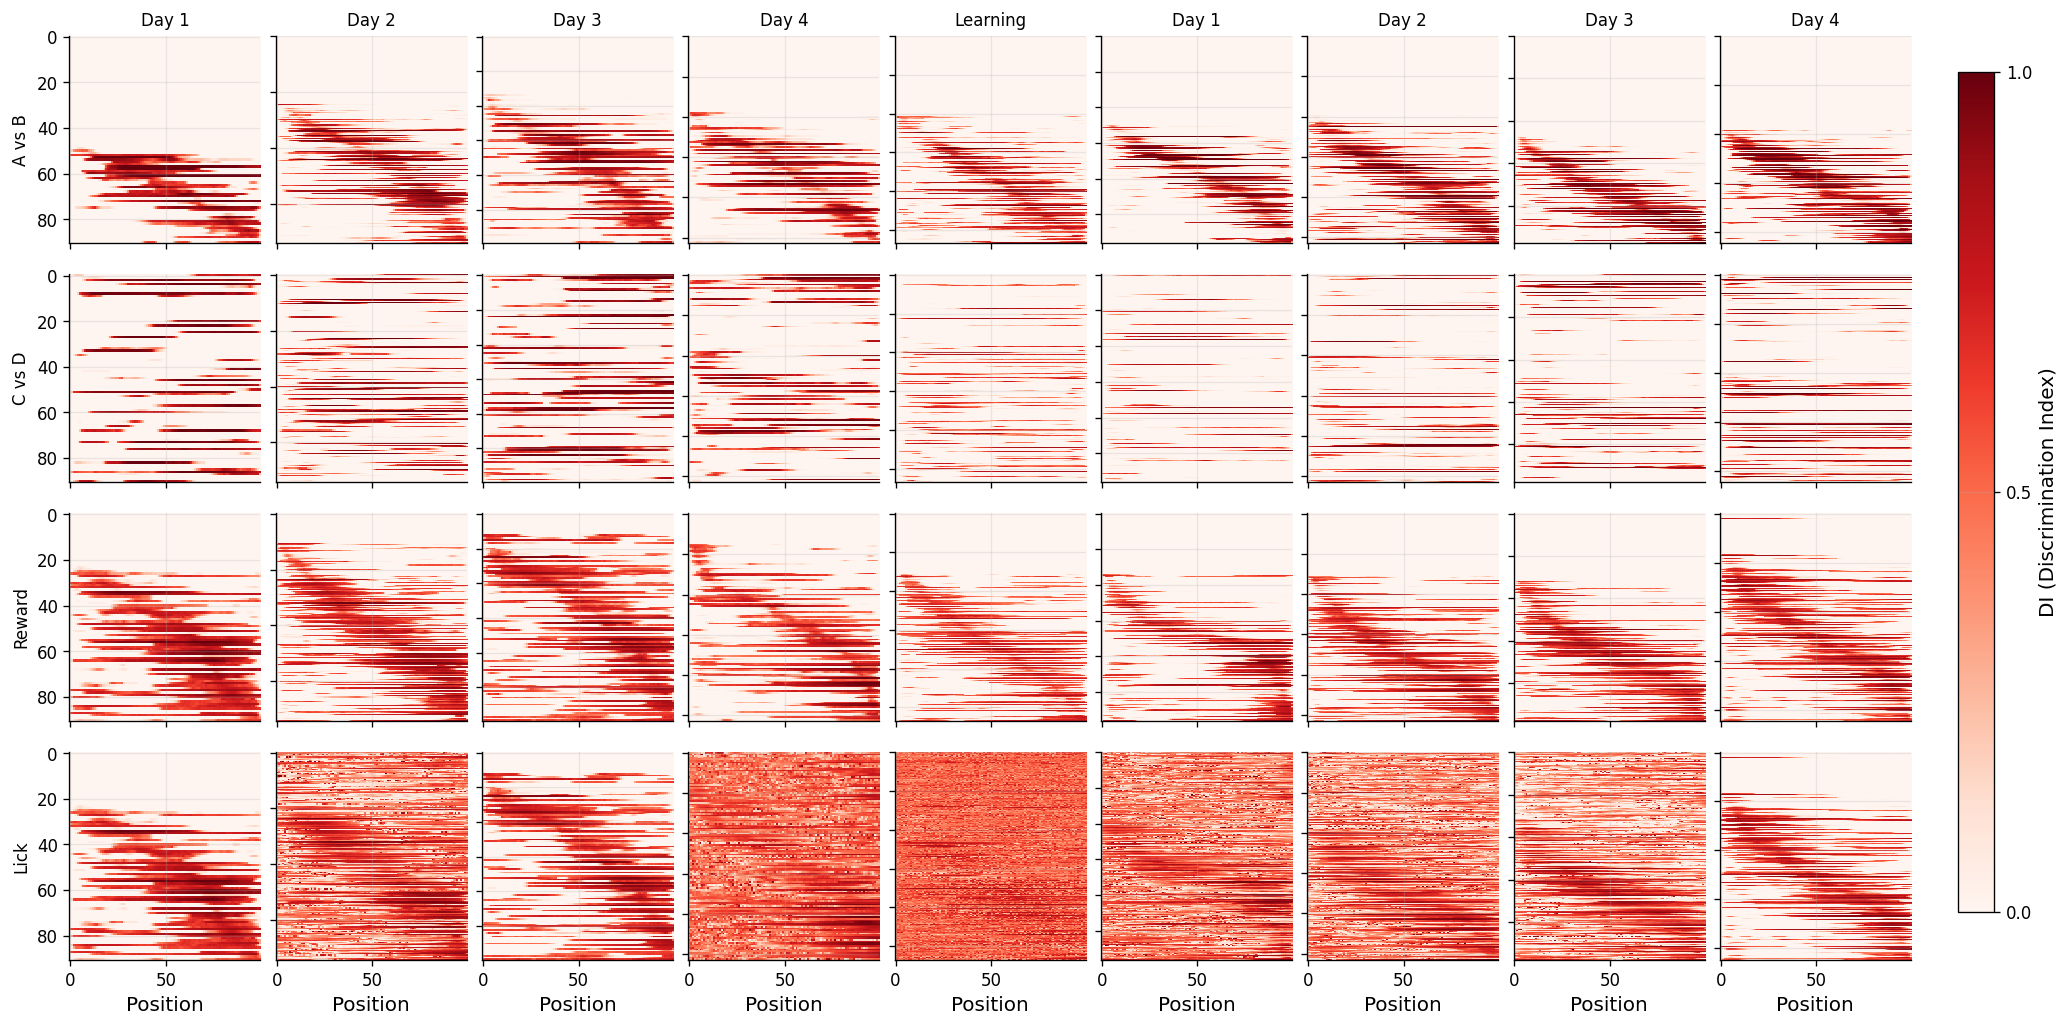

In [18]:
fig = figure_3b(H5_PATH, MOUSE_ID, ABCD_SESSIONS, LEARNING_SESSION, EFGH_SESSIONS)